# Sales Analysis Notebook
This notebook performs analysis on sales data, including visualizations and key metrics.

In [21]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import glob
import numpy as np
import xlsxwriter  # Added for Excel export

# Set plot style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## Data Loading
Load the latest sales data, either from PDI output or the original dataset.

In [ ]:
def load_latest_data():
    pdi_output_path = r"/home/jovyan/pdi-output"
    
    # Check for PDI output files
    detailed_files = glob.glob(os.path.join(pdi_output_path, "sales_detailed_*.csv"))
    
    if not detailed_files:
        # Fallback to original dataset if no PDI output
        print("No PDI output found, using original dataset...")
        original_data = pd.read_csv(r"/home/jovyan/datasets/sales_data.csv")
        
        # Basic processing
        original_data['total_amount'] = original_data['quantity'] * original_data['unit_price']
        original_data['profit_margin'] = (original_data['total_amount'] - (original_data['quantity'] * original_data['cost'])) / original_data['total_amount']
        original_data['order_date'] = pd.to_datetime(original_data['order_date'])
        original_data['month_year'] = original_data['order_date'].dt.to_period('M')
        
        return original_data
    
    # Load PDI processed data
    latest_detailed = max(detailed_files, key=os.path.getctime)
    detailed_df = pd.read_csv(latest_detailed)
    print(f"Loaded PDI processed data: {os.path.basename(latest_detailed)}")
    
    return detailed_df

data = load_latest_data()
print(f"Data loaded: {len(data)} records")

## Data Exploration
Let's take a look at the structure and summary of our data.

In [23]:
print("Data Overview:")
display(data.head())
print("\nData Info:")
data.info()

Data Overview:


,order_id,customer_id,product_name,product_category,quantity,unit_price,cost,order_date,total_amount,profit_margin,month_year
0,1001,CUST001,Widget A,Electronics,2,25.99,15.0,2024-01-15,51.98,0.422855,2024-01
1,1002,CUST002,Gadget B,Electronics,1,45.50,25.0,2024-01-15,45.50,0.450549,2024-01
2,1003,CUST001,Tool C,Hardware,3,12.99,8.0,2024-01-16,38.97,0.384142,2024-01
3,1004,CUST003,Device D,Electronics,1,89.99,45.0,2024-01-17,89.99,0.499944,2024-01
4,1005,CUST002,Part E,Hardware,5,7.50,4.0,2024-01-18,37.50,0.466667,2024-01



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          10 non-null     int64         
 1   customer_id       10 non-null     object        
 2   product_name      10 non-null     object        
 3   product_category  10 non-null     object        
 4   quantity          10 non-null     int64         
 5   unit_price        10 non-null     float64       
 6   cost              10 non-null     float64       
 7   order_date        10 non-null     datetime64[ns]
 8   total_amount      10 non-null     float64       
 9   profit_margin     10 non-null     float64       
 10  month_year        10 non-null     period[M]     
dtypes: datetime64[ns](1), float64(4), int64(2), object(3), period[M](1)
memory usage: 1012.0+ bytes


## Data Visualization
Create visualizations to understand sales patterns and performance.

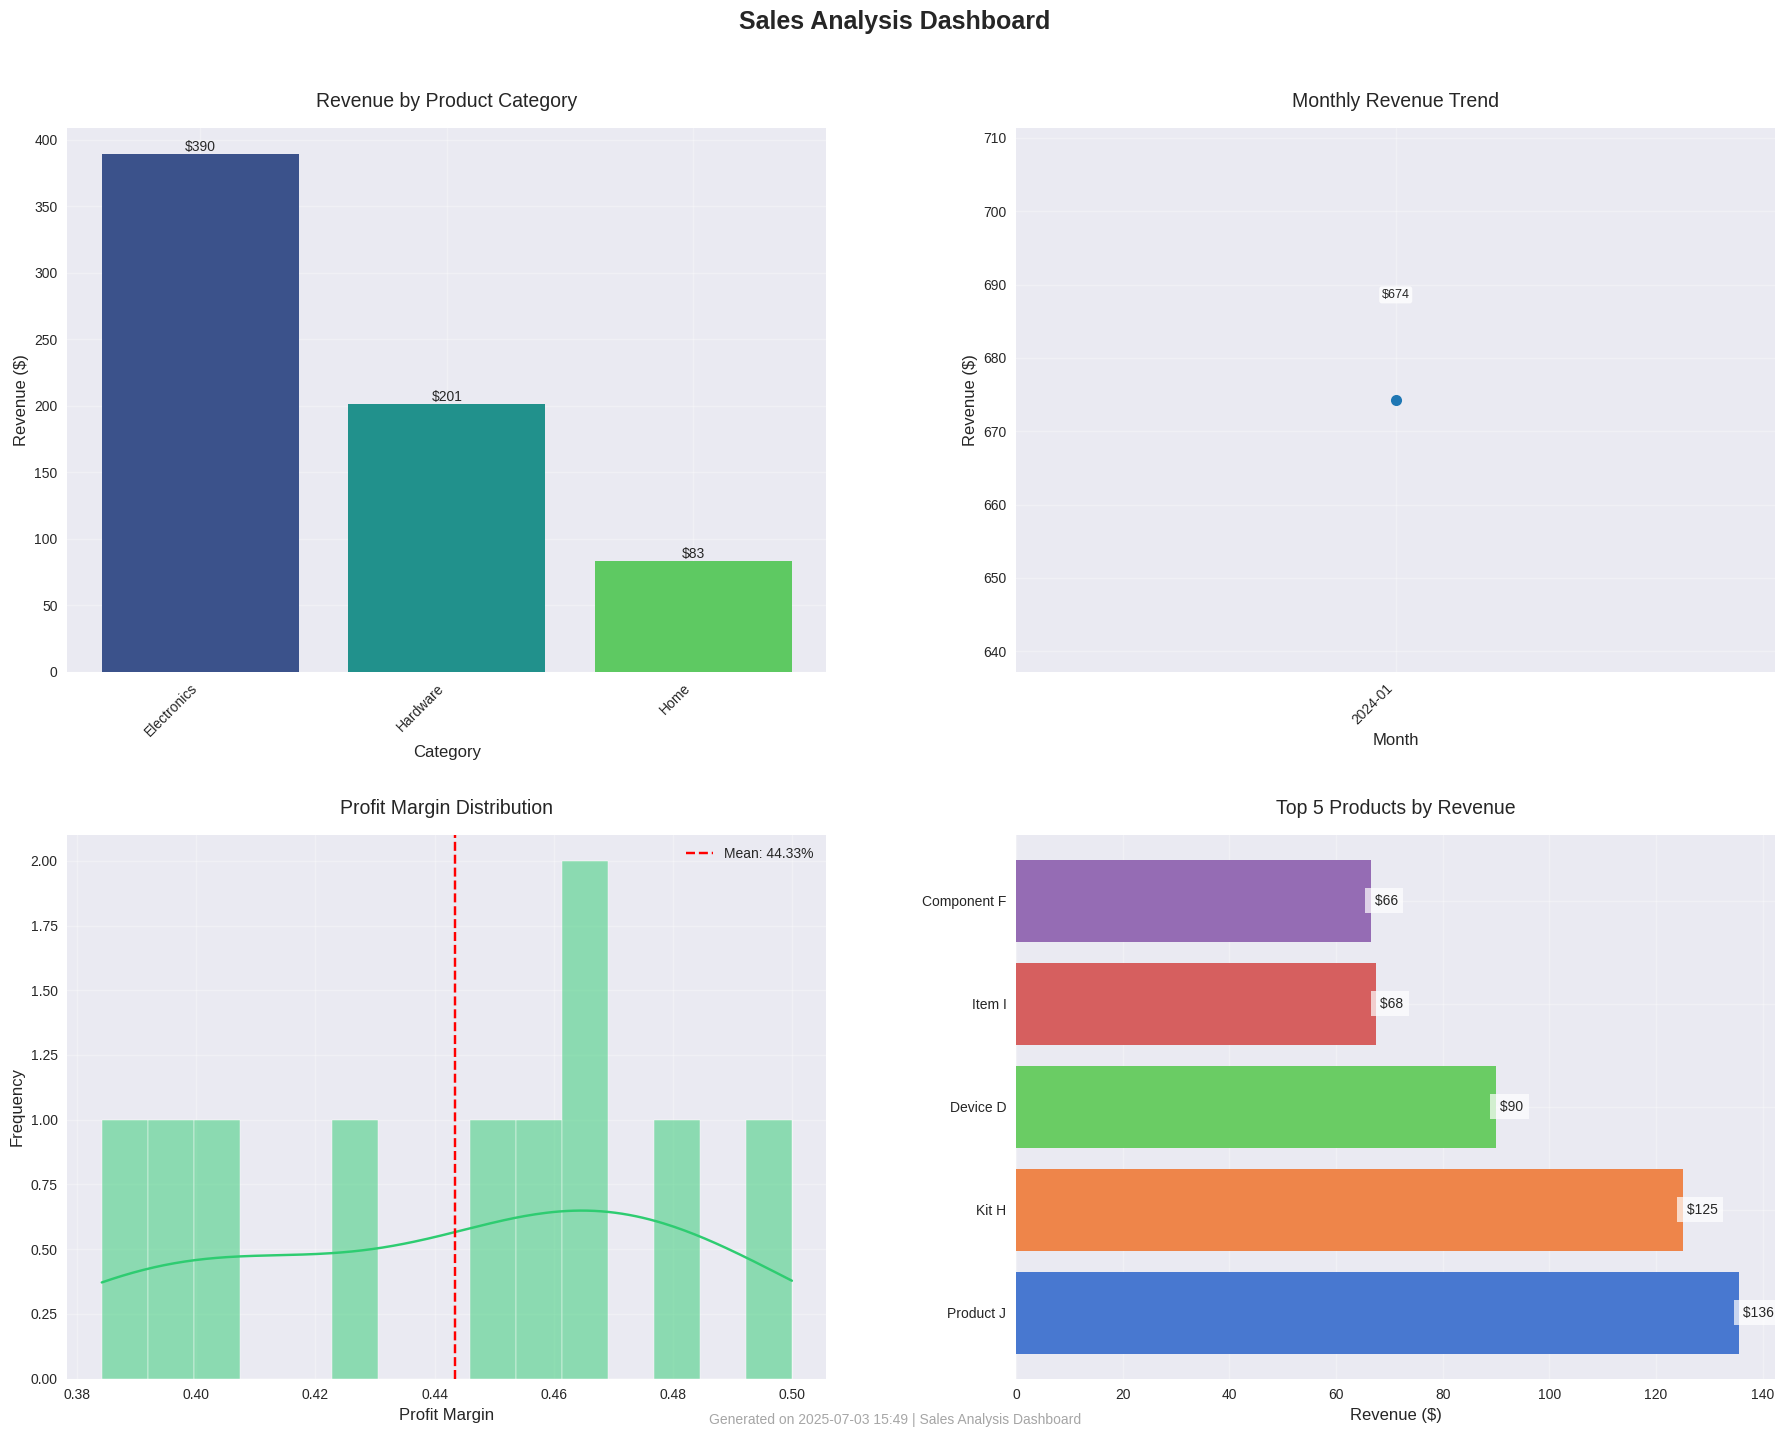

In [24]:
# Create figure with a larger size
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Sales Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)

# 1. Revenue by Category (Enhanced)
category_revenue = data.groupby('product_category')['total_amount'].sum().sort_values(ascending=False)
colors = sns.color_palette('viridis', len(category_revenue))
bars = axes[0, 0].bar(category_revenue.index, category_revenue.values, color=colors)
axes[0, 0].set_title('Revenue by Product Category', fontsize=14, pad=15)
axes[0, 0].set_xlabel('Category', fontsize=12)
axes[0, 0].set_ylabel('Revenue ($)', fontsize=12)
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:,.0f}',
                   ha='center', va='bottom', fontsize=10)

# 2. Monthly Revenue (Enhanced)
if 'order_date' in data.columns:
    monthly_revenue = data.groupby('month_year')['total_amount'].sum()
    months = monthly_revenue.index.astype(str)  # Convert PeriodIndex to strings
    x = range(len(months))
    
    # Create line plot with markers
    line = axes[0, 1].plot(x, monthly_revenue.values, 
                          marker='o', 
                          linestyle='-', 
                          color='#1f77b4',
                          linewidth=2.5,
                          markersize=8)
    
    axes[0, 1].set_title('Monthly Revenue Trend', fontsize=14, pad=15)
    axes[0, 1].set_xlabel('Month', fontsize=12)
    axes[0, 1].set_ylabel('Revenue ($)', fontsize=12)
    
    # Format x-axis with month-year labels
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(months, rotation=45, ha='right')
    
    # Add data labels
    for i, v in enumerate(monthly_revenue.values):
        axes[0, 1].text(i, v + (max(monthly_revenue)*0.02), 
                       f'${v:,.0f}',
                       ha='center', 
                       va='bottom',
                       fontsize=9,
                       bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # Remove top and right spines
    axes[0, 1].spines[['top', 'right']].set_visible(False)

# 3. Profit Margin Distribution (Enhanced)
sns.histplot(data['profit_margin'], 
             bins=15, 
             kde=True, 
             color='#2ecc71',
             edgecolor='white',
             ax=axes[1, 0])
axes[1, 0].set_title('Profit Margin Distribution', fontsize=14, pad=15)
axes[1, 0].set_xlabel('Profit Margin', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(data['profit_margin'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {data["profit_margin"].mean():.2%}')
axes[1, 0].legend()

# 4. Top Products (Enhanced)
top_products = data.groupby('product_name')['total_amount'].sum().sort_values(ascending=False).head(5)
colors = sns.color_palette('muted', len(top_products))
bars = axes[1, 1].barh(top_products.index, top_products.values, color=colors)
axes[1, 1].set_title('Top 5 Products by Revenue', fontsize=14, pad=15)
axes[1, 1].set_xlabel('Revenue ($)', fontsize=12)
# Add value labels on the bars
for i, (name, value) in enumerate(zip(top_products.index, top_products.values)):
    axes[1, 1].text(value, i, f' ${value:,.0f}',
                   va='center', ha='left', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Add watermark
fig.text(0.5, 0.01, f'Generated on {datetime.now().strftime("%Y-%m-%d %H:%M")} | Sales Analysis Dashboard', 
         ha='center', fontsize=10, color='gray', alpha=0.7)

plt.show()

## Key Metrics
Calculate and display important business metrics.

In [25]:
total_revenue = data['total_amount'].sum()
avg_order_value = data['total_amount'].mean()
total_orders = len(data)
avg_profit_margin = data['profit_margin'].mean()

from IPython.display import display, HTML

metrics_html = f"""
<div style='background-color:#f8f9fa; padding:15px; border-radius:5px;'>
    <h3>Key Metrics</h3>
    <table style='width:100%'>
        <tr>
            <td><strong>Total Revenue:</strong></td>
            <td>${total_revenue:,.2f}</td>
        </tr>
        <tr>
            <td><strong>Average Order Value:</strong></td>
            <td>${avg_order_value:,.2f}</td>
        </tr>
        <tr>
            <td><strong>Total Orders:</strong></td>
            <td>{total_orders:,}</td>
        </tr>
        <tr>
            <td><strong>Average Profit Margin:</strong></td>
            <td>{avg_profit_margin:.2%}</td>
        </tr>
    </table>
</div>
"""

display(HTML(metrics_html))

Total Revenue:,$674.29
Average Order Value:,$67.43
Total Orders:,10
Average Profit Margin:,44.33%


## Export Results
Save the analysis results and visualizations.

In [26]:
# Create reports directory if it doesn't exist
output_dir = "/home/jovyan/reports"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamp for the report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = os.path.join(output_dir, f'sales_analysis_{timestamp}.xlsx')

try:
    # Create a Pandas Excel writer using XlsxWriter as the engine
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        # Write summary metrics
        summary_df = pd.DataFrame({
            'Metric': ['Total Revenue', 'Average Order Value', 'Total Orders', 'Average Profit Margin'],
            'Value': [f'${total_revenue:,.2f}', f'${avg_order_value:,.2f}', 
                     f'{total_orders:,}', f'{avg_profit_margin:.2%}']
        })
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # Write detailed data
        data.to_excel(writer, sheet_name='Detailed Data', index=False)
        
        # Get the workbook and worksheet objects
        workbook = writer.book
        worksheet = writer.sheets['Summary']
        
        # Add a format for the header
        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'fg_color': '#4472C4',
            'font_color': 'white',
            'border': 1
        })
        
        # Write the column headers with the defined format
        for col_num, value in enumerate(summary_df.columns.values):
            worksheet.write(0, col_num, value, header_format)
            
        # Auto-adjust column widths
        for i, col in enumerate(summary_df.columns):
            # Find length of column i
            column_len = max(summary_df[col].astype(str).str.len().max(), len(col)) + 2
            # Set the column width
            worksheet.set_column(i, i, column_len)
            
    print(f"Analysis results saved to: {output_file}")
    
except Exception as e:
    print(f"Error saving Excel file: {e}")
    print("Trying alternative export method...")
    # Fallback to CSV if Excel export fails
    try:
        csv_file = os.path.join(output_dir, f'sales_analysis_{timestamp}.csv')
        data.to_csv(csv_file, index=False)
        print(f"Data exported to CSV: {csv_file}")
    except Exception as e2:
        print(f"Failed to export data: {e2}")

Analysis results saved to: /home/jovyan/reports/sales_analysis_20250703_155010.xlsx
